# ¿Cuál es un mejor plan?

Por medio del siguiente proyecto llevaremos a cabo un estudio para saber cuáles de los planes de Megaline generan más ingresos, con el fin de ajustar el presupuesto de la publicidad. Los planes a estudiar son el plan **Surf** y el plan **Ultimate**.

Para esto realizaremos un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendremos los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Al analizar el comportamiento de los clientes,determinaremos qué tarifa de prepago genera más ingresos.


## Inicialización

Primero cargamos las librerías necesarias para llevar a cabo el estudio.

In [ ]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import ttest_ind
import math

## Cargar los datos

A continuación cargamos todos los DataFrames

In [ ]:
# Cargamos los archivos de datos en diferentes DataFrames
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')


## Preparar los datos

Los datos para este proyecto se dividen en varias tablas. De este modo, exploraremos cada una para tener una comprensión inicial de los datos. Si es necesario, haremos las correcciones necesarias para cada tabla.

## Comenzaremos con el DataFrame **'calls'**.

In [ ]:
# Echamos un vistazo a nuestra tabla
calls.head(10)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
5,1000_388,1000,2018-12-31,2.20
6,1000_510,1000,2018-12-27,5.75
7,1000_521,1000,2018-12-28,14.18
8,1000_530,1000,2018-12-28,5.77
9,1000_544,1000,2018-12-26,4.40


In [ ]:
# Revisamos su información general
print(calls.info())
print()
print(calls.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None

(137735, 4)


In [ ]:
# Revisamos las columnas para ver si hay algún espacio demás que no podamos ver
calls.columns

Index(['id', 'user_id', 'call_date', 'duration'], dtype='object')

In [ ]:
# Revisamos su distribución
calls.describe()

,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


In [ ]:
# Revisamos si hay datos duplicados
calls.duplicated().sum()

0

Si bien no hay valores ausentes, al ver la distribución podemos ver llamadas de 0 segundos, probablemente porque son llamadas perdidas. Veremos cuántas de estas hay para decidir qué haremos con estos datos.

In [ ]:
# Revisamos cuántas llamadas con 0 segundos hay.
missed = calls.duration[calls.duration == 0].count()
print(f"Cantidad de llamadas perdidas: {missed}")
missed_perc = calls.duration[calls.duration == 0].count() / len(calls.duration)*100
print(f"porcentaje de llamadas perdidas: {int(missed_perc)}%")

Cantidad de llamadas perdidas: 26834
porcentaje de llamadas perdidas: 19%


Como podemos ver, **el 19% de las llamadas corresponden a llamadas perdidas**, por lo que no manipularemos estos datos ya que corresponden a un gran porcentaje del DataFrame.

 Al analizar la tabla **calls** encontramos lo siguiente:

 - 1. El DataFrame **calls** se compone de 137.735 filas y 4 columnas.
 - 2. El formato de de los nombres de las columnas está correcto.
 - 3. Al revisar la información general no encontramos valores ausentes.
 - 4. No tenemos valores duplicados.
 - 5. La columna **call_date está en formato object, que pasaremos a formato Datetime**, por si en el futuro debemos analizar fechas.
 - 6. Además, **la columna duration la pasaremos a tipo Timedelta y redondearemos los segundos a minutos**. En este caso cada llamada individual se redondea; incluso si la llamada duró solo un segundo, se contará como un minuto.
 - 7. El valor mínimo de la columna **duration** es 0, el máximo es 38, su media es 6.7 y mediana 5.9.  Valores bastante normales a excepción de los 0.
 - 8. Un 19% se las llamadas tienen una duración de 0 segundos, estas probablemente son llamadas perdidas.

### Corregir datos

Aquí corregiremos lo que observamos con anterioridad.

In [ ]:
# Cambiamos de formato la columna 'calls_date' a Datetime
calls.call_date = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [ ]:
# Cambiamos de formato la columna 'duration' a Timedelta
calls['duration'] = pd.to_timedelta(calls['duration'], unit='m')

In [ ]:
# redondeamos los segundos a minutos
calls['duration'] = calls['duration'].apply(lambda x: pd.Timedelta(minutes=math.ceil(x.seconds/60)))

In [ ]:
# vemos que esté todo bien con los formatos
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype          
---  ------     --------------   -----          
 0   id         137735 non-null  object         
 1   user_id    137735 non-null  int64          
 2   call_date  137735 non-null  datetime64[ns] 
 3   duration   137735 non-null  timedelta64[ns]
dtypes: datetime64[ns](1), int64(1), object(1), timedelta64[ns](1)
memory usage: 4.2+ MB


In [ ]:
# Revisamos la columna 'duration'
calls.head(10)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,0 days 00:09:00
1,1000_145,1000,2018-12-27,0 days 00:14:00
2,1000_247,1000,2018-12-27,0 days 00:15:00
3,1000_309,1000,2018-12-28,0 days 00:06:00
4,1000_380,1000,2018-12-30,0 days 00:05:00
5,1000_388,1000,2018-12-31,0 days 00:03:00
6,1000_510,1000,2018-12-27,0 days 00:06:00
7,1000_521,1000,2018-12-28,0 days 00:15:00
8,1000_530,1000,2018-12-28,0 days 00:06:00
9,1000_544,1000,2018-12-26,0 days 00:05:00


Como podemos ver, cambiamos los formatos de forma exitosa y los segundos se redondearon a minutos; incluso si la llamada duró solo un segundo, se contará como un minuto a partir de ahora.

### Enriquecemos los datos

Aquí agregaremos dos columnas con el número de llamadas realizadas y minutos utilizados al mes, llamadas **calls_monthly** y **minutes_monthly** respectivamente.

In [ ]:
# Agregamos una nueva columna con el número de llamadas por mes por usuario

calls['calls_monthly'] = calls.groupby(['user_id', calls['call_date'].dt.month])['id'].transform('count')

In [ ]:
# Revisamos la columna 'calls_monthly'
calls.head(15)

,id,user_id,call_date,duration,calls_monthly
0,1000_93,1000,2018-12-27,0 days 00:09:00,16
1,1000_145,1000,2018-12-27,0 days 00:14:00,16
2,1000_247,1000,2018-12-27,0 days 00:15:00,16
3,1000_309,1000,2018-12-28,0 days 00:06:00,16
4,1000_380,1000,2018-12-30,0 days 00:05:00,16
5,1000_388,1000,2018-12-31,0 days 00:03:00,16
6,1000_510,1000,2018-12-27,0 days 00:06:00,16
7,1000_521,1000,2018-12-28,0 days 00:15:00,16
8,1000_530,1000,2018-12-28,0 days 00:06:00,16
9,1000_544,1000,2018-12-26,0 days 00:05:00,16


In [ ]:
# Aquí agregaremos la columna 'minutes_monthly'
calls['minutes_monthly'] = calls.groupby(['user_id', calls['call_date'].dt.month])['duration'].transform('sum')

In [ ]:
# Revisamos la nueva columna 'minutes_monthly'
calls.head(15)

,id,user_id,call_date,duration,calls_monthly,minutes_monthly
0,1000_93,1000,2018-12-27,0 days 00:09:00,16,0 days 02:04:00
1,1000_145,1000,2018-12-27,0 days 00:14:00,16,0 days 02:04:00
2,1000_247,1000,2018-12-27,0 days 00:15:00,16,0 days 02:04:00
3,1000_309,1000,2018-12-28,0 days 00:06:00,16,0 days 02:04:00
4,1000_380,1000,2018-12-30,0 days 00:05:00,16,0 days 02:04:00
5,1000_388,1000,2018-12-31,0 days 00:03:00,16,0 days 02:04:00
6,1000_510,1000,2018-12-27,0 days 00:06:00,16,0 days 02:04:00
7,1000_521,1000,2018-12-28,0 days 00:15:00,16,0 days 02:04:00
8,1000_530,1000,2018-12-28,0 days 00:06:00,16,0 days 02:04:00
9,1000_544,1000,2018-12-26,0 days 00:05:00,16,0 days 02:04:00


Al revisar nuestras nuevas columnas, todo se ve en orden!

## Seguimos con el Dataframe **'internet'**.

In [ ]:
# Echamos un vistazo a nuestra tabla
internet.head(15)

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
5,1001_0,1001,2018-08-24,284.68
6,1001_3,1001,2018-12-09,656.04
7,1001_4,1001,2018-11-04,16.97
8,1001_10,1001,2018-11-27,135.18
9,1001_15,1001,2018-12-13,761.92


In [ ]:
# Revisamos su información general
print(internet.info())
print()
print(internet.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None

(104825, 4)


In [ ]:
# Revisamos las columnas para ver que esté todo en orden
internet.columns

Index(['id', 'user_id', 'session_date', 'mb_used'], dtype='object')

In [ ]:
# Revisamos su distribución
internet.describe()

,user_id,mb_used
count,104825.000000,104825.000000
mean,1242.496361,366.713701
std,142.053913,277.170542
min,1000.000000,0.000000
25%,1122.000000,136.080000
50%,1236.000000,343.980000
75%,1367.000000,554.610000
max,1499.000000,1693.470000


In [ ]:
# Revisamos si hay datos duplicados
internet.duplicated().sum()

0

Al analizar la tabla **internet** encontramos lo siguiente:

 - 1. El DataFrame **internet** se compone de 104.825 filas y 4 columnas.
 - 2. El formato de los nombres de las columnas está correcto.
 - 3. Al revisar la información general no encontramos valores ausentes.
 - 4. No tenemos valores duplicados.
 - 5. La columna **session_date** está en formato object, **que pasaremos a formato Datetime**, por si en el futuro debemos analizar fechas.
 - 6. El valor mínimo de la columna **mb_used** es 0, el máximo es 1.693, su media es 366 y mediana 344.
 - 7. **En este caso, el total del mes se redondea hacia arriba. Si alguien usa 1025 megabytes este mes, se le cobrarán 2 gigabytes. De este modo, crearemos una nueva columna en GB y con los valores redondeados**.

### Corregimos los datos

In [ ]:
# Pasamos la columna 'session_date' a formato Datetime
internet.session_date = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

### Enriquecemos los datos

Ahora creamos una nueva columna '**mg_monthly**' con el volumen de datos por mes en MB por cada usuario.

In [ ]:
# Sacamos el total de mb por mes por usuario
# Utilizamos la función transform para agregar la columna al dataframe original y que coincidan los índices
internet['mg_monthly'] = internet.groupby(['user_id', pd.Grouper(key='session_date', freq='M')])['mb_used'].transform('sum')

Creamos una nueva columna '**gb_monthly_rounded**' con los datos en **GB** redondeados, con el fin de alcular el consumo de datos.

In [ ]:
internet['gb_monthly'] = internet['mg_monthly'] / 1024
internet['gb_monthly_rounded'] = np.ceil(internet['mg_monthly'] / 1024)

In [ ]:
# Revisamos nuestra nueva columna 'gb_monthly_rounded'
internet.head(10)

,id,user_id,session_date,mb_used,mg_monthly,gb_monthly,gb_monthly_rounded
0,1000_13,1000,2018-12-29,89.86,1901.47,1.856904,2.0
1,1000_204,1000,2018-12-31,0.00,1901.47,1.856904,2.0
2,1000_379,1000,2018-12-28,660.40,1901.47,1.856904,2.0
3,1000_413,1000,2018-12-26,270.99,1901.47,1.856904,2.0
4,1000_442,1000,2018-12-27,880.22,1901.47,1.856904,2.0
5,1001_0,1001,2018-08-24,284.68,6919.15,6.756982,7.0
6,1001_3,1001,2018-12-09,656.04,19369.18,18.915215,19.0
7,1001_4,1001,2018-11-04,16.97,18504.30,18.070605,19.0
8,1001_10,1001,2018-11-27,135.18,18504.30,18.070605,19.0
9,1001_15,1001,2018-12-13,761.92,19369.18,18.915215,19.0


In [ ]:
# Revisamos que esté todo bien con nuestras columnas
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  104825 non-null  object        
 1   user_id             104825 non-null  int64         
 2   session_date        104825 non-null  datetime64[ns]
 3   mb_used             104825 non-null  float64       
 4   mg_monthly          104825 non-null  float64       
 5   gb_monthly          104825 non-null  float64       
 6   gb_monthly_rounded  104825 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 5.6+ MB


Como se puede ver, **agregamos la columna 'bg_monthly_rounded'** con la que calcularemos el consumo de datos; y **pasamos la columna 'session_date' a formato Datetime**.

## Seguimos con el DataFrame **'messages'**.

In [ ]:
# Echamos un vistazo a nuestra tabla
print(messages.head(10))
print()
print(messages.tail(10))

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26
5  1000_346     1000   2018-12-29
6  1000_386     1000   2018-12-30
7  1000_413     1000   2018-12-31
8  1000_502     1000   2018-12-27
9  1000_525     1000   2018-12-28

             id  user_id message_date
76041  1497_502     1497   2018-12-30
76042  1497_503     1497   2018-12-29
76043  1497_507     1497   2018-12-23
76044  1497_517     1497   2018-12-17
76045  1497_524     1497   2018-12-12
76046  1497_526     1497   2018-12-24
76047  1497_536     1497   2018-12-24
76048  1497_547     1497   2018-12-31
76049  1497_558     1497   2018-12-24
76050  1497_613     1497   2018-12-23


In [ ]:
# Revisamos su información general
print(messages.info())
print()
print(messages.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None

(76051, 3)


In [ ]:
# Revisamos las columnas para ver que esté todo en orden
messages.columns

Index(['id', 'user_id', 'message_date'], dtype='object')

**En este caso no es necesario revisar distribución, ya que solo hay dos columnas con 'ids' y una con fechas.**

In [ ]:
# Revisamos si hay datos duplicados
messages.duplicated().sum()

0

Al analizar la tabla **messages** encontramos lo siguiente:

 - 1. El DataFrame **messages** se compone de 76.051 filas y 3 columnas.
 - 2. El formato de de los nombres de las columnas está correcto.
 - 3. Al revisar la información general no encontramos valores ausentes.
 - 4. No tenemos valores duplicados.
 - 5. La columna **message_date** está en formato object, **que pasaremos a formato Datetime**, por si en el futuro debemos analizar fechas.
 - 7. En este caso no fue necesario revisar distribución, ya que solo hay dos columnas con 'ids' y una con fechas.

### Corregimos los datos

In [ ]:
# Cambiamos 'message_date' a formato Datetime
messages.message_date = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [ ]:
# Revisamos los cambios
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enriquecer los datos

Aquí agregaremos una columna con la cantidad de los SMS enviados por mes. La llamaremos **sms_monthly**.

In [ ]:
# Agregar una columna con el número de mensajes por mes para cada usuario
messages['sms_monthly'] = messages.groupby(['user_id', messages['message_date'].dt.month])['id'].transform('count')

In [ ]:
# Revisamos la columna 'sms_monthly'
messages

,id,user_id,message_date,sms_monthly
0,1000_125,1000,2018-12-27,11
1,1000_160,1000,2018-12-31,11
2,1000_223,1000,2018-12-31,11
3,1000_251,1000,2018-12-27,11
4,1000_255,1000,2018-12-26,11
...,...,...,...,...
76046,1497_526,1497,2018-12-24,50
76047,1497_536,1497,2018-12-24,50
76048,1497_547,1497,2018-12-31,50
76049,1497_558,1497,2018-12-24,50


Como se puede observar, pasamos la columna **'message_date'** a formato **Datetime**. También agregamo una nueva columna con la cantidad de SMS enviados por mes por cada usuario, llamada **sms_monthly**.

## Revisamos el Dataframe **'plans'**.

In [ ]:
# Echamos un vistazo a nuestra tabla
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [ ]:
# Revisamos su información general
print(plans.info())
print()
print(plans.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes
None

(2, 8)


In [ ]:
# Revisamos las columnas para ver que esté todo en orden
plans.columns

Index(['messages_included', 'mb_per_month_included', 'minutes_included',
       'usd_monthly_pay', 'usd_per_gb', 'usd_per_message', 'usd_per_minute',
       'plan_name'],
      dtype='object')

**En este caso no es necesario revisar distribución, ya que solo hay dos filas que representan los valores de las características de los planes 'Surf' y 'Ultimate'**.

**Tampoco revisaremos duplicados ya que solo tenemos dos filas**

Al analizar la tabla **plans** encontramos lo siguiente:

 - 1. El DataFrame **plans** se compone de 2 filas y 8 columnas.
 - 2. El formato de de los nombres de las columnas está correcto.
 - 3. Al revisar la información general no encontramos valores ausentes.
 - 4. No tenemos valores duplicados.
 - 5. Los formatos de las columnas son correctos.
 - 7. En este caso no fue necesario revisar distribución, ya que solo hay dos filas que representan los valores de las características de los plabes 'Surf' y 'Ultimate'.

 Con esta tabla está todo en orden.

###  Finalmente revisamos el DataFrame **'users'**.

In [ ]:
# Echamos un vistazo a nuestra tabla
users.head(15)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaN
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaN
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaN


In [ ]:
# Revisamos su información general
print(users.info())
print()
print(users.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None

(500, 8)


Podemos ver que en la columna **'churn_date'** hay valores ausentes. Los revisaremos un poco más a fondo.

In [ ]:
# Revisamos los valores ausentes de la columna 'churn_date'
user_isna = users.churn_date.isna().sum()
user_isna_perc = users.churn_date.isna().sum() / len(users.churn_date)*100
print(f"Número de valores ausentes en columna 'churn_date': {user_isna}")
print(f"Porcentaje de valores ausentes en columna 'churn_date': {int(user_isna_perc)}%")

Número de valores ausentes en columna 'churn_date': 466
Porcentaje de valores ausentes en columna 'churn_date': 93%


In [ ]:
# Revisamos las columnas para ver que esté todo en orden
users.columns

Index(['user_id', 'first_name', 'last_name', 'age', 'city', 'reg_date', 'plan',
       'churn_date'],
      dtype='object')

In [ ]:
# Revisamos su distribución
users.describe()

,user_id,age
count,500.000000,500.000000
mean,1249.500000,45.486000
std,144.481833,16.972269
min,1000.000000,18.000000
25%,1124.750000,30.000000
50%,1249.500000,46.000000
75%,1374.250000,61.000000
max,1499.000000,75.000000


In [ ]:
# Revisamos si hay datos duplicados
users.duplicated().sum()

0

 Al analizar la tabla **users** encontramos lo siguiente:

 - 1. El DataFrame **users** se compone de 500 filas y 8 columnas.
 - 2. El formato de de los nombres de las columnas está correcto, **a excepción de 'reg_date' que reemplazaremos por 'subscription_date'**.
 - 3. Al revisar la información general vemos que la columna **churn_date** tiene valores ausentes. El 93% de los valores de esta columna son valores ausentes.
 - 4. No tenemos valores duplicados.
 - 5. La columna **'reg_date' y 'churn_date' están en formato object, que pasaremos a formato Datetime**, por si en el futuro debemos analizar fechas.
 - 7. El valor mínimo de la columna **age** es 18, el máximo es 75, su media es 45 y mediana 46. Con las edades se ve todo bien.

### Corregir los datos

Para '**churn_date**' el 93% de los datos están ausentes, esta columna representa la fecha en que los clientes abandonaron sus planes. Al no saber estas fechas, imputaremos con 'unknown'.

In [ ]:
# Cambiamos el nombre de la columna 'reg_date' a 'subcription_date' que es más representativo
users.rename(columns={'reg_date': 'subscription_date'}, inplace=True)

In [ ]:
# Cambiamos de formato la columna 'subscription_date' a Datetime
users.subscription_date = pd.to_datetime(users['subscription_date'], format='%Y-%m-%d')

In [ ]:
# Cambiamos de formato la columna 'churn_date' a Datetime
users.churn_date = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [ ]:
# Imputamos con 'unknown'
users['churn_date'].fillna('unknown', inplace=True)

In [ ]:
# echamos un vistazo a los cambios
users.head(15)

,user_id,first_name,last_name,age,city,subscription_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,unknown
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,unknown
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,unknown
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,unknown
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,unknown
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,unknown
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18 00:00:00
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,unknown
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,unknown
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,unknown


In [ ]:
# Comprobamos los cambios
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            500 non-null    int64         
 1   first_name         500 non-null    object        
 2   last_name          500 non-null    object        
 3   age                500 non-null    int64         
 4   city               500 non-null    object        
 5   subscription_date  500 non-null    datetime64[ns]
 6   plan               500 non-null    object        
 7   churn_date         500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


Hemos dejado todo en orden!

## Estudiar las condiciones del plan

Es sumamente importante entender cómo funcionan los planes, cómo se cobra a los usuarios con base en su plan de suscripción. Por lo tanto visualizaremos la información del plan para ver una vez más sus condiciones.

In [ ]:
# Imprime las condiciones del plan y asegúrate de que te resulten claros
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Las condiciones del plan **Surf** son las siguientes:

1. Pago mensual: 20
2. 500 minutos al mes, 50 SMS y 15 GB de datos
3. Si se exceden los límites del paquete:
 - minuto: 3 centavos
 - SMS: 3 centavos
 - GB de datos: 10$


Y las condiciones del plan **Ultimate** son:

1. Pago mensual: 70
2. 3000 minutos al mes, 1000 SMS y 30 GB de datos
3. Si se exceden los límites del paquete:
 - 1 minuto: 1 centavo
 - 1 SMS: 1 centavo
 - 1 GB de datos: 7$

## Agregar datos por usuario

- Ahora que los datos están limpios, agregaremos los datos por usuario por periodo para poder tener solo un registro por usuario por periodo. Esto facilitará mucho su posterior análisis.


- Aquí además cambiaremos los nombres de las columnas que contienen fechas, a **'date'**, de modo que no haya problemas al unir las tablas con el método '.merge()'.


- También cambiaremos los nombres de las columnas **'id'** por otros más representativos.

In [ ]:
# Calcula el número de llamadas hechas por cada usuario por mes. Guarda el resultado.
calls_monthly_df = calls.groupby(['user_id', pd.Grouper(key='call_date', freq='M')])['id'].agg('count').reset_index()

# Cambiamos el nombre de la columna 'id' por 'calls_per_month'
calls_monthly_df = calls_monthly_df.rename(columns={'id':'calls_per_month'})

# Cambiamos el nombre de la columna 'call_date' por 'date'
calls_monthly_df = calls_monthly_df.rename(columns={'call_date':'date'})


In [ ]:
# Calcula la cantidad de minutos que usó cada usuario por mes. Guarda el resultado.
minutes_monthly_df = calls.groupby(['user_id', pd.Grouper(key='call_date', freq='M')])['duration'].agg('sum').reset_index()

# Cambiamos el nombre de la columna 'call_date' por 'date'
minutes_monthly_df = minutes_monthly_df.rename(columns={'call_date':'date'})


In [ ]:
# Calcula el número de mensajes enviados por cada usuario por mes. Guarda el resultado.
sms_monthly_df = messages.groupby(['user_id', pd.Grouper(key='message_date', freq='M')])['id'].agg('count').reset_index()

# Cambiamos el nombre de la columna 'id' por 'calls_per_month'
sms_monthly_df = sms_monthly_df.rename(columns={'id':'sms_per_month'})

# Cambiamos el nombre de la columna 'message_date' por 'date'
sms_monthly_df = sms_monthly_df.rename(columns={'message_date':'date'})


In [ ]:
# Calcula el volumen del tráfico de internet usado por cada usuario por mes. Guarda el resultado.
mb_monthly_df = internet.groupby(['user_id', pd.Grouper(key='session_date', freq='M')])['mb_used'].agg('sum').reset_index()
mb_monthly_df['gb_usage'] = np.ceil(mb_monthly_df['mb_used']/1024)

# Cambiamos el nombre de la columna 'session_date' por 'date'
mb_monthly_df = mb_monthly_df.rename(columns={'session_date':'date'})


A continuación juntaremos todos los datos obtenidos previamente, en un **DataFrame llamado 'megaline'**. Es decir, el número de llamadas, duración de llamadas, mensajes enviados e internet usado por mes para cada cliente.

In [ ]:
# Combina los datos para las llamadas, minutos, mensajes e internet con base en el user_id y el mes
df_1 = calls_monthly_df.merge(minutes_monthly_df, on=['user_id', 'date'], how='outer')
df_2 = df_1.merge(sms_monthly_df, on=['user_id', 'date'], how='outer')
megaline = df_2.merge(mb_monthly_df, on=['user_id', 'date'], how='outer')

In [ ]:
# Echamos un vistazo a nuestra tabla con los datos unidos
megaline.head()

,user_id,date,calls_per_month,duration,sms_per_month,mb_used,gb_usage
0,1000,2018-12-31,16.0,0 days 02:04:00,11.0,1901.47,2.0
1,1001,2018-08-31,27.0,0 days 03:02:00,30.0,6919.15,7.0
2,1001,2018-09-30,49.0,0 days 05:15:00,44.0,13314.82,14.0
3,1001,2018-10-31,65.0,0 days 06:33:00,53.0,22330.49,22.0
4,1001,2018-11-30,64.0,0 days 07:06:00,36.0,18504.30,19.0


En este caso solo usaremos la columna **'gb_usage'** para el volumen de dato por cliente, por lo que quitaremos la columna **'mb_used'** de nuestro DataFrame. Y a la columna **'duration'** le daremos un nombre más representativo. La llamaremos **'call_time_monthly'**.

In [ ]:
# Quitamos la columna 'mb_used'
megaline.drop('mb_used', axis= 1, inplace=True)

In [ ]:
# A la columna 'duration' le daremos un nombre más representativo. La llamaremos 'call_time_monthly'
megaline = megaline.rename(columns={'duration':'call_time_monthly'})

In [ ]:
# Damos otro breve vistazo
megaline.head(5)

,user_id,date,calls_per_month,call_time_monthly,sms_per_month,gb_usage
0,1000,2018-12-31,16.0,0 days 02:04:00,11.0,2.0
1,1001,2018-08-31,27.0,0 days 03:02:00,30.0,7.0
2,1001,2018-09-30,49.0,0 days 05:15:00,44.0,14.0
3,1001,2018-10-31,65.0,0 days 06:33:00,53.0,22.0
4,1001,2018-11-30,64.0,0 days 07:06:00,36.0,19.0


In [ ]:
# Revisamos la distribución de nuestra nueva tabla
megaline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   user_id            2293 non-null   int64          
 1   date               2293 non-null   datetime64[ns] 
 2   calls_per_month    2258 non-null   float64        
 3   call_time_monthly  2258 non-null   timedelta64[ns]
 4   sms_per_month      1806 non-null   float64        
 5   gb_usage           2277 non-null   float64        
dtypes: datetime64[ns](1), float64(3), int64(1), timedelta64[ns](1)
memory usage: 125.4 KB


Al ver la distribución podemos ver que las columnas **'calls_per_month', 'call_time_monthly', 'sms_per_month'**, y '**gb_usage'** tienen datos ausentes.

In [ ]:
# Calculamos el porcentaje de valores ausentes para cada columna
nacalls = megaline.calls_per_month.isna().sum() / len(megaline) * 100
natime = megaline.call_time_monthly.isna().sum() / len(megaline) * 100
nasms = megaline.sms_per_month.isna().sum() / len(megaline) * 100
nagb = megaline.gb_usage.isna().sum() / len(megaline) * 100

print(f"Porcentaje de valores ausentes en 'calls_per_month': {nacalls}%")
print(f"Porcentaje de valores ausentes en 'call_time_monthly': {natime}%")
print(f"Porcentaje de valores ausentes en 'sms_per_month': {nasms}%")
print(f"Porcentaje de valores ausentes en 'gb_usage': {nagb}%")


Porcentaje de valores ausentes en 'calls_per_month': 1.526384648931531%
Porcentaje de valores ausentes en 'call_time_monthly': 1.526384648931531%
Porcentaje de valores ausentes en 'sms_per_month': 21.238552115133015%
Porcentaje de valores ausentes en 'gb_usage': 0.697775839511557%


Aquí podemos ver que los sms son el medio menos utilizado, debido a que **en este caso los valores ausentes hacen referencia a no consumo. De este modo, lo mejor será imputar los valores ausentes con 0**.

Primero imputamos los valores de la columna 'call_time_monthly' que está en formato datetime64.

In [ ]:
# Rellenamos los NaN de 'call_time_monthly' con 0
megaline.call_time_monthly.fillna(pd.Timedelta(minutes=0), inplace=True)

In [ ]:
# Imputamos las demás columnas con 0
megaline.calls_per_month.fillna(0, inplace=True)
megaline.sms_per_month.fillna(0, inplace=True)
megaline.gb_usage.fillna(0, inplace=True)

In [ ]:
# Revisamos que esté todo en orden
megaline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   user_id            2293 non-null   int64          
 1   date               2293 non-null   datetime64[ns] 
 2   calls_per_month    2293 non-null   float64        
 3   call_time_monthly  2293 non-null   timedelta64[ns]
 4   sms_per_month      2293 non-null   float64        
 5   gb_usage           2293 non-null   float64        
dtypes: datetime64[ns](1), float64(3), int64(1), timedelta64[ns](1)
memory usage: 125.4 KB


Como podemos ver nuestro DataFrame ya se encuentra sin valores ausentes. A continuación añadiremos la información de los usuarios y sus respectivos planes.

Comenzaremos cambiando el nombre de la columna **'plan'** del DataFrame 'users' a **'plan_name'** para llevar a cabo de forma exitosa la unión con el DataFrame **'plans'**.


In [ ]:
# Cambiamos nombre de columna 'plan' a 'plan_name'
users.rename(columns={'plan': 'plan_name'}, inplace=True)

In [ ]:
# Añadimos la información del plan y los usuarios
megalinev2 = megaline.merge(users, on='user_id')
megalinev3 = megalinev2.merge(plans, on='plan_name')

In [ ]:
# Revisamos nuestra nueva tabla
megalinev3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   user_id                2293 non-null   int64          
 1   date                   2293 non-null   datetime64[ns] 
 2   calls_per_month        2293 non-null   float64        
 3   call_time_monthly      2293 non-null   timedelta64[ns]
 4   sms_per_month          2293 non-null   float64        
 5   gb_usage               2293 non-null   float64        
 6   first_name             2293 non-null   object         
 7   last_name              2293 non-null   object         
 8   age                    2293 non-null   int64          
 9   city                   2293 non-null   object         
 10  subscription_date      2293 non-null   datetime64[ns] 
 11  plan_name              2293 non-null   object         
 12  churn_date             2293 non-null   object   

In [ ]:
# Le damos un vistazo
megalinev3

,user_id,date,calls_per_month,call_time_monthly,sms_per_month,gb_usage,first_name,last_name,age,city,subscription_date,plan_name,churn_date,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute
0,1000,2018-12-31,16.0,0 days 02:04:00,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,unknown,1000,30720,3000,70,7,0.01,0.01
1,1006,2018-11-30,2.0,0 days 00:10:00,15.0,3.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18 00:00:00,1000,30720,3000,70,7,0.01,0.01
2,1006,2018-12-31,9.0,0 days 00:59:00,139.0,32.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18 00:00:00,1000,30720,3000,70,7,0.01,0.01
3,1008,2018-10-31,71.0,0 days 07:55:00,21.0,17.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,unknown,1000,30720,3000,70,7,0.01,0.01
4,1008,2018-11-30,63.0,0 days 07:26:00,37.0,24.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,unknown,1000,30720,3000,70,7,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1194,2018-11-30,0.0,0 days 00:00:00,62.0,42.0,Robert,Mclean,40,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-05-31,surf,unknown,50,15360,500,20,10,0.03,0.03
2289,1194,2018-12-31,0.0,0 days 00:00:00,56.0,31.0,Robert,Mclean,40,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-05-31,surf,unknown,50,15360,500,20,10,0.03,0.03
2290,1349,2018-10-31,0.0,0 days 00:00:00,76.0,13.0,Florentina,Diaz,69,"Boston-Cambridge-Newton, MA-NH MSA",2018-10-01,surf,unknown,50,15360,500,20,10,0.03,0.03
2291,1349,2018-11-30,0.0,0 days 00:00:00,72.0,17.0,Florentina,Diaz,69,"Boston-Cambridge-Newton, MA-NH MSA",2018-10-01,surf,unknown,50,15360,500,20,10,0.03,0.03


Pasaremos la columna **'mb_per_month_included'** de mb a gb y la renombraremos como **'gb_per_month_included'**, para no tener problemas en calcular el excedente por usuario más adelante.

In [ ]:
# En este caso pasaremos la columna 'mb_per_month_included' de mg a gb
megalinev3['mb_per_month_included'] = megalinev3['mb_per_month_included'] / 1024

# Cambiamos el nombre de la columna a 'gb_per_month_included'
megalinev3.rename(columns={'mb_per_month_included': 'gb_per_month_included'}, inplace=True)

Ya teniendo nuestras tablas unidas con la información de los usuarios, las especificaciones de los planes y el uso de sms, internet y llamadas por usuarios por mes, calcularemos los ingresos mensuales por usuario. Para esto restaremos el límite del paquete gratuito del número total de llamadas, SMS y datos; y multiplicaremos el resultado por el valor de tarifa de llamadas, SMS y datos, respectivamente.

### Primero calcularemos el excedente de uso de intenet en GB. Para esto crearemos la columna **'gb_surplus_charge'**.

In [ ]:
# Creamos la columna 'gb_surplus_charge'
megalinev3['gb_surplus_charge'] = megalinev3['gb_per_month_included'] - megalinev3['gb_usage']

Sus valores positivos los dejaremos en 0, ya que no representan un excedente. Y los valores negativos los pasaremos a positivos, ya que representan el excedente de gb, que será multiplicado por el valor de la tarifa de los gb del plan respectivo.

In [ ]:
# Dejamos los valores positivos en 0
megalinev3['gb_surplus_charge'] = megalinev3['gb_surplus_charge'].apply(lambda x: x if x < 0 else 0)

In [ ]:
# Pasamos los valores negativos a positivos y los multiplicamos por el costo de la tarifa de gb (usd_per_gb)
megalinev3['gb_surplus_charge'] = megalinev3['gb_surplus_charge'].abs() * megalinev3['usd_per_gb']

In [ ]:
# Echamos un vistazo a nuestra columna
megalinev3['gb_surplus_charge']

0         0.0
1         0.0
2        14.0
3         0.0
4         0.0
        ...  
2288    270.0
2289    160.0
2290      0.0
2291     20.0
2292      0.0
Name: gb_surplus_charge, Length: 2293, dtype: float64

### Continuamos con el excedente de sms. Para esto crearemos la columna **'sms_surplus_charge'**.

Para crear las siguientes columnas seguiremos la misma lógica que utilizamos para crear la columna 'gb_surplus_charge'.

In [ ]:
# Creamos la columna 'sms_surplus_charge'
megalinev3['sms_surplus_charge'] = megalinev3['messages_included'] - megalinev3['sms_per_month']

In [ ]:
# Dejamos los valores positivos en 0
megalinev3['sms_surplus_charge'] = megalinev3['sms_surplus_charge'].apply(lambda x: x if x < 0 else 0)

In [ ]:
# Pasamos los valores negativos a positivos y los multiplicamos por el costo de la tarifa de gb (usd_per_gb)
megalinev3['sms_surplus_charge'] = megalinev3['sms_surplus_charge'].abs() * megalinev3['usd_per_message']

In [ ]:
# Revisamos la columna
megalinev3['sms_surplus_charge']

0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
        ... 
2288    0.36
2289    0.18
2290    0.78
2291    0.66
2292    0.33
Name: sms_surplus_charge, Length: 2293, dtype: float64

### Calculamos el excedente de los minutos para las llamadas. Para esto crearemos la columna 'minutes_surplus_charge'.

En este caso la columna con la que queremos hacer los cálculos (**'call_time_monthly'**) está en formato timedelta64, que la pasaremos a int64 para no tener problemas al hacer los cálculos.

In [ ]:
# Extraer los minutos de la columna 'call_time_monthly'
megalinev3['call_time_monthly'] = (megalinev3['call_time_monthly'].dt.total_seconds() / 60).round().astype('int64')

In [ ]:
# Revisamos que se hayan efectuado los cambios
megalinev3['call_time_monthly']

0       124
1        10
2        59
3       475
4       446
       ... 
2288      0
2289      0
2290      0
2291      0
2292      0
Name: call_time_monthly, Length: 2293, dtype: int64

Los cambios se llevaron a cabo con éxito, ahora aplicaremos el proceso utilizado anteriormente.

In [ ]:
# Creamos la columna 'minutes_surplus_charge'
megalinev3['minutes_surplus_charge'] = megalinev3['minutes_included'] - megalinev3['call_time_monthly']

In [ ]:
# Dejamos los valores positivos en 0
megalinev3['minutes_surplus_charge'] = megalinev3['minutes_surplus_charge'].apply(lambda x: x if x < 0 else 0)

In [ ]:
# Pasamos los valores negativos a positivos y los multiplicamos por el costo de la tarifa de gb (usd_per_gb)
megalinev3['minutes_surplus_charge'] = megalinev3['minutes_surplus_charge'].abs() * megalinev3['usd_per_minute']

In [ ]:
# Revisamos nuestra nueva columna
megalinev3['minutes_surplus_charge']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2288    0.0
2289    0.0
2290    0.0
2291    0.0
2292    0.0
Name: minutes_surplus_charge, Length: 2293, dtype: float64

### Finalmente calcula el ingreso mensual para cada usuario.

Para esto crearemos la columna **'total_surplus_charge'** que guardará el total de los excedentes calculados anteriormente. Luego crearemos la columna **'user_monthly_income'**, que guardará los ingresos mensuales por usuario. Esto lo haremos sumando la columna **'total_surplus_charge'** la columna **'usd_monthly_pay'**.

In [ ]:
# Sumamos los excedentes
megalinev3['total_surplus_charge'] = megalinev3['gb_surplus_charge'] + megalinev3['sms_surplus_charge'] + megalinev3['minutes_surplus_charge']

In [ ]:
# Creamos la columna 'user_monthly_income'
megalinev3['user_monthly_income'] = megalinev3['total_surplus_charge'] + megalinev3['usd_monthly_pay']

In [ ]:
# Revisamos nuestra valiosa columna
megalinev3['user_monthly_income']

0        70.00
1        70.00
2        84.00
3        70.00
4        70.00
         ...  
2288    290.36
2289    180.18
2290     20.78
2291     40.66
2292     20.33
Name: user_monthly_income, Length: 2293, dtype: float64

In [ ]:
# Revisamos las características de nuestro nuevo DataFrame
megalinev3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   user_id                 2293 non-null   int64         
 1   date                    2293 non-null   datetime64[ns]
 2   calls_per_month         2293 non-null   float64       
 3   call_time_monthly       2293 non-null   int64         
 4   sms_per_month           2293 non-null   float64       
 5   gb_usage                2293 non-null   float64       
 6   first_name              2293 non-null   object        
 7   last_name               2293 non-null   object        
 8   age                     2293 non-null   int64         
 9   city                    2293 non-null   object        
 10  subscription_date       2293 non-null   datetime64[ns]
 11  plan_name               2293 non-null   object        
 12  churn_date              2293 non-null   object  

In [ ]:
# visualizamos nuestro DataFrame actualizado
megalinev3

,user_id,date,calls_per_month,call_time_monthly,sms_per_month,gb_usage,first_name,last_name,age,city,...,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_surplus_charge,sms_surplus_charge,minutes_surplus_charge,total_surplus_charge,user_monthly_income
0,1000,2018-12-31,16.0,124,11.0,2.0,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",...,3000,70,7,0.01,0.01,0.0,0.00,0.0,0.00,70.00
1,1006,2018-11-30,2.0,10,15.0,3.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,3000,70,7,0.01,0.01,0.0,0.00,0.0,0.00,70.00
2,1006,2018-12-31,9.0,59,139.0,32.0,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",...,3000,70,7,0.01,0.01,14.0,0.00,0.0,14.00,84.00
3,1008,2018-10-31,71.0,475,21.0,17.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,3000,70,7,0.01,0.01,0.0,0.00,0.0,0.00,70.00
4,1008,2018-11-30,63.0,446,37.0,24.0,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",...,3000,70,7,0.01,0.01,0.0,0.00,0.0,0.00,70.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1194,2018-11-30,0.0,0,62.0,42.0,Robert,Mclean,40,"San Jose-Sunnyvale-Santa Clara, CA MSA",...,500,20,10,0.03,0.03,270.0,0.36,0.0,270.36,290.36
2289,1194,2018-12-31,0.0,0,56.0,31.0,Robert,Mclean,40,"San Jose-Sunnyvale-Santa Clara, CA MSA",...,500,20,10,0.03,0.03,160.0,0.18,0.0,160.18,180.18
2290,1349,2018-10-31,0.0,0,76.0,13.0,Florentina,Diaz,69,"Boston-Cambridge-Newton, MA-NH MSA",...,500,20,10,0.03,0.03,0.0,0.78,0.0,0.78,20.78
2291,1349,2018-11-30,0.0,0,72.0,17.0,Florentina,Diaz,69,"Boston-Cambridge-Newton, MA-NH MSA",...,500,20,10,0.03,0.03,20.0,0.66,0.0,20.66,40.66


Y listo! ya tenemos toda la información necesaria para comenzar con nuestro análisis.

## Estudia el comportamiento del usuario

A continuación calcularemos algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibujaremos gráficos para facilitar la comprensión. Dado que la tarea principal es comparar los planes y decidir cuál es más rentable, las estadísticas y gráficas serán calculadas por plan.

### Llamadas

Comenzaremos comparando la duración promedio de llamadas por cada plan por cada mes y las visualizaremos con gráficos de barras. Para esto, crearemos dos dataframes filtrados por los planes llamados: **'megaline_ultimate'** y **'megaline_surf'**.

In [ ]:
# Creamos la tabla 'megaline_ultimate'
megaline_ultimate = megalinev3[megalinev3['plan_name'] == 'ultimate']

In [ ]:
# Creamos la tabla 'megaline_surf'
megaline_surf = megalinev3[megalinev3['plan_name'] == 'surf']

In [ ]:
# Comparamos la duración promedio de llamadas por cada plan por cada mes. Los visualizaremos por medio de un gráfico de barras.
## Primero guardamos los promedios de la duración de las llamadas por mes y por plan
call_mean_ultimate = megaline_ultimate.pivot_table(index='date', values='call_time_monthly')
call_mean_surf = megaline_surf.pivot_table(index='date', values='call_time_monthly')

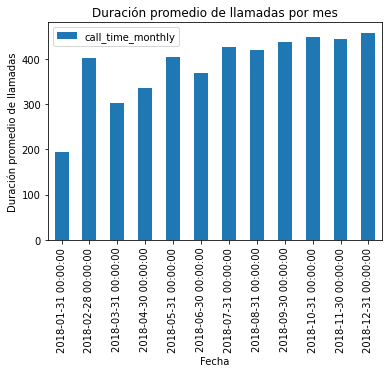

In [ ]:
# Graficamos la duración promedio de llamadas por mes del plan ultimate
call_mean_ultimate.plot(kind='bar')

plt.xlabel('Fecha')
plt.ylabel('Duración promedio de llamadas')
plt.title('Duración promedio de llamadas por mes')

plt.show()

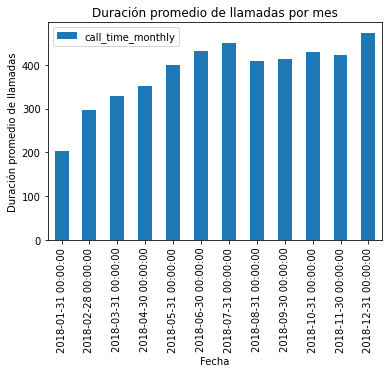

In [ ]:
# Graficamos la duración promedio de llamadas por mes del plan ultimate
call_mean_surf.plot(kind='bar')

plt.xlabel('Fecha')
plt.ylabel('Duración promedio de llamadas')
plt.title('Duración promedio de llamadas por mes')

plt.show()

Los gráficos muestran que en ambos planes, el promedio de llamadas de enero a diciembre va en aumento, aunque de forma irregular.
En ambo casos en enero hay un promedio de alrededor de 200 minutos.Una diferencia significativa es que en el plan **ultimate**, el promedio del mes de febrero alcanza los 400 minutos, mientras que en el plan **surf**, para este mes solo alcanza los 300 minutos. Además, en ambos planes en el mes de diciembre se encuentra el promedio más alto, valores cernanos a los 460 minutos.

A continuación compararemos el número de minutos que los usuarios de cada plan requieren cada mes por medio de un histograma.

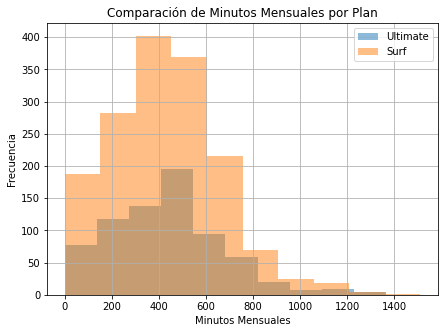

In [ ]:
# Compara el número de minutos que los usuarios de cada plan requieren cada mes. Traza un histograma.
plt.figure(figsize=(7, 5))
plt.hist(megaline_ultimate['call_time_monthly'], bins=10, alpha=0.5, label='Ultimate')
plt.hist(megaline_surf['call_time_monthly'], bins=10, alpha=0.5, label='Surf')

plt.grid(True)
plt.xlabel('Minutos Mensuales')
plt.ylabel('Frecuencia')
plt.title('Comparación de Minutos Mensuales por Plan')
plt.legend()

plt.show()

In [ ]:
# Calcularemos la cantidad de usuarios para saber porqué las frecuencias son diferentes
len_ult = len(users[users['plan_name']=='ultimate'])
len_surf = len(users[users['plan_name']=='surf'])
print(f"cantidad de usuarios con plan ultimate: {len_ult}")
print(f"cantidad de usuarios con plan surf: {len_surf}")

cantidad de usuarios con plan ultimate: 161
cantidad de usuarios con plan surf: 339


Como era de esperarse, la frecuencia del plan **surf** es bastante superior a la del plan **ultimate**, debido a la cantidad de usuarios.

**Plan Surf**:
 - Alcanza el pick de frecuencia (400) entre los 300 y 450 minutos, es decir, son los tiempos más utilizados por mes por los clientes.
 - Luego este pick comienza a descender bastante en los 900 minutos mensuales. Después de los 1000 minutos por mes, la frecuencia de usuarios es bastante baja.

**Plan Ultimate**:
 - Alcanza su pick de frecuencia (200) entre los 400 y 550 minutos mensuales, es decir, son los minutos mensuales que utiliza la mayoría de usuarios.
 - A partir de los 550 minutos el pick compienza a descender hasta los 950 minutos. A partie de los 950 los clientes son bastante escasos.

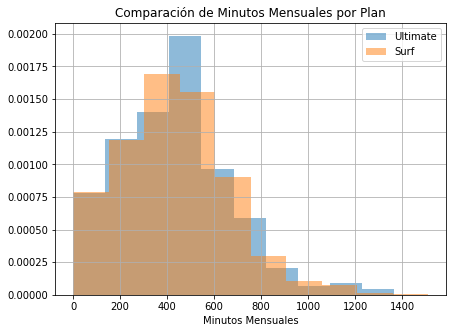

In [ ]:
# Además imprimiremos la proporción en lugar de los conteos
# Compara el número de minutos que los usuarios de cada plan requieren cada mes. Traza un histograma.
plt.figure(figsize=(7, 5))
plt.hist(megaline_ultimate['call_time_monthly'], bins=10, alpha=0.5, label='Ultimate', density=True)
plt.hist(megaline_surf['call_time_monthly'], bins=10, alpha=0.5, label='Surf', density=True)

plt.grid(True)
plt.xlabel('Minutos Mensuales')
plt.title('Comparación de Minutos Mensuales por Plan')
plt.legend()

plt.show()


Ahora calcularemos la media y la variable de la duración de la llamada por plan, para concluir si los usuarios de diferentes planes muestran comportamientos distintos para sus llamadas.

In [ ]:
# Calculamos la media y la varianza de la duración mensual de llamadas del plan 'Ultimate'

print(f"La media de la duración mensual de llamadas es: {megaline_ultimate['call_time_monthly'].mean()}")
print(f"La varianza de la duración mensual de llamadas es: {np.var(megaline_ultimate['call_time_monthly'])}")

La media de la duración mensual de llamadas es: 429.9402777777778
La varianza de la duración mensual de llamadas es: 57622.71171103395


In [ ]:
# Calculamos la media y la varianza de la duración mensual de llamadas del plan 'Surf'

print(f"La media de la duración mensual de llamadas es: {megaline_surf['call_time_monthly'].mean()}")
print(f"La varianza de la duración mensual de llamadas es: {np.var(megaline_surf['call_time_monthly'])}")

La media de la duración mensual de llamadas es: 428.25619834710744
La varianza de la duración mensual de llamadas es: 54809.40607251502


Para ambos planes, tanto la media como la varianza son casi idénticas. La media de **ultimate** es 429 y la de **Surf** es 428. La varianza de **ultimate** es 57.622 y la de **surf** es 54.622.

 - Para ambos planes el promedio de minutos es cercano a los 430 minutos por mes.
 - Respecto a la varianza de los planes, ambas indican que la dispersión de los valores en relación a la media es relativamente alta.

Para continuar trazaremos un diagrama de caja para visualizar la distribución de la duración mensual de llamadas en ambos planes.

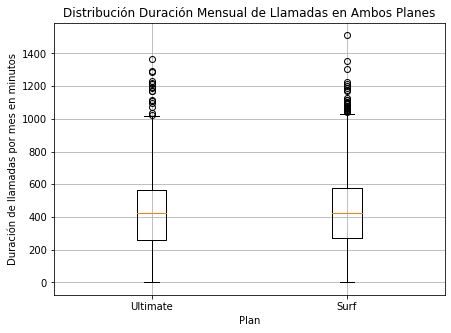

In [ ]:
# Trazamos un diagrama de caja para visualizar la distribución de la duración mensual de llamadas en ambos planes.

data_ultimate = megaline_ultimate['call_time_monthly']
data_surf = megaline_surf['call_time_monthly']
data = [data_ultimate, data_surf]

plt.figure(figsize=(7, 5))
plt.boxplot(data, labels=['Ultimate', 'Surf'])
plt.xlabel('Plan')
plt.ylabel('Duración de llamadas por mes en minutos')
plt.title('Distribución Duración Mensual de Llamadas en Ambos Planes')
plt.grid(True)
plt.show()

In [ ]:
# Asismismo revisamos la distribución de llamadas en ambos planes de forma más exacta
# Distribución duración llamadas plan ultimate
megaline_ultimate['call_time_monthly'].describe()

count     720.000000
mean      429.940278
std       240.214185
min         0.000000
25%       259.750000
50%       423.000000
75%       564.250000
max      1365.000000
Name: call_time_monthly, dtype: float64

In [ ]:
# Distribución duración llamadas plan ultimate
megaline_surf['call_time_monthly'].describe()

count    1573.000000
mean      428.256198
std       234.188540
min         0.000000
25%       271.000000
50%       425.000000
75%       575.000000
max      1510.000000
Name: call_time_monthly, dtype: float64

Como revisamos anteriormente, para la duración de llamadas por mes por usuario **'call_time_monthly'**:
 - La cantidad de usuarios con plan ultimate 161 y plan surf 339.
 - Al revisar el histograma, el plan **surf** alcanza valores más altos en términos de frecuencia debido a que tiene alrededor del doble de usuarios del plan **ultimate**. El plan surf alcanza el pick de frecuencia (400) entre los 300 y 450 minutos. Y el plan ultimate alcanza su pick de frecuencia (200) entre los 400 y 550 minutos mensuales.
 - Al observar la distribución con '.describe()' y el diagrama de caja, podemos ver que sus medias y medianas son muy similares. Sus medias son 429, 428 y sus medianas 423 y 425.
 - La varianza en ambos planes también es bastante similar, la de 'ultimate' es 57622 y la de surf es '54809'.

 De modo más general, ambos planes se comportan de manera bastante similar, sin embargo, el plan surf tiene más usuarios que el plan ultimate. Con esto podemos teorizar que el plan surf genera más ingresos.


### Mensajes

Ahora estudiaremos el parámetro **'sms_per_month'**, que contiene la cantidad de mensajes enviados por mes por cada usuario. Comenzaremos comparando el número de mensajes enviados por mes por los usuarios de ambos planes.

Primero compararemos el promedio de mensajes que tienden a enviar cada mes los usuarios de cada plan. Esto lo haremos por medio de gráficos de barra.

In [ ]:
# Guardamos los promedios de sms enviados por mes y por plan
sms_mean_ultimate = megaline_ultimate.pivot_table(index='date', values='sms_per_month')
sms_mean_surf = megaline_surf.pivot_table(index='date', values='sms_per_month')

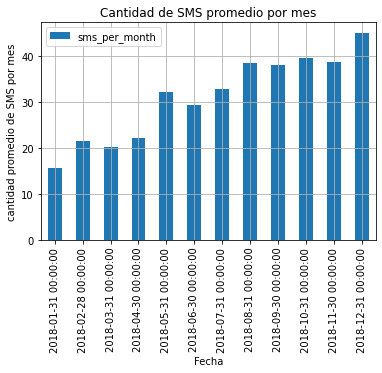

In [ ]:
# Graficamos la cantidad promedio de sms por mes del plan ultimate
sms_mean_ultimate.plot(kind='bar')

plt.xlabel('Fecha')
plt.ylabel('cantidad promedio de SMS por mes')
plt.title('Cantidad de SMS promedio por mes')

plt.grid(True)
plt.show()

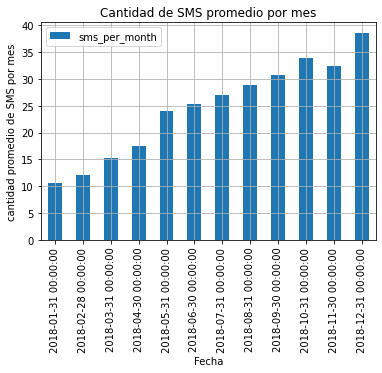

In [ ]:
# Graficamos la duración promedio de llamadas por mes del plan surf
sms_mean_surf.plot(kind='bar')

plt.xlabel('Fecha')
plt.ylabel('cantidad promedio de SMS por mes')
plt.title('Cantidad de SMS promedio por mes')

plt.grid(True)
plt.show()

Al observar los gráficos podemos ver que el el promedio de mensajes enviados por mes va aumentando de forma más o menos pareja desde enero a diciembre. Sin embargo, se puede notar que los promedios del plan **'ultimte'** son más altos.

A continuación compararemos el número de sms que los usuarios de cada plan requieren cada mes por medio de un histograma.

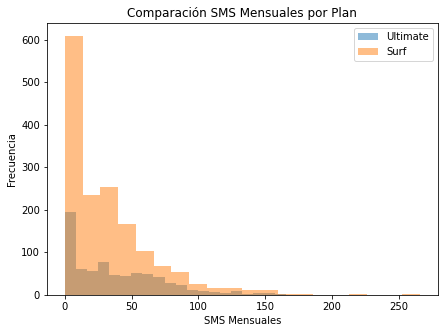

In [ ]:
# Comparamos el número de sms que los usuarios de cada plan requieren cada mes por medio de un histograma.
plt.figure(figsize=(7, 5))
plt.hist(megaline_ultimate['sms_per_month'], bins=20, alpha=0.5, label='Ultimate')
plt.hist(megaline_surf['sms_per_month'], bins=20, alpha=0.5, label='Surf')

plt.xlabel('SMS Mensuales')
plt.ylabel('Frecuencia')
plt.title('Comparación SMS Mensuales por Plan')
plt.legend()

plt.show()

Por medio del histograma podemos ver que en ambos planes los datos están sesgados hacia la derecha. También podemos observar que la frecuencia del plan surf es bastante superior debido a su cantidad de usuarios. Además podemos notar que en el plan **surf** se envían más SMS por usuario que en el plan **ultimate** (266 versus 166), aunque los usuarios que envían esta cantidad de mensajes son escasos. Por otra parte, el comportamiento representado en la forma de los histogramas es bastante similar: ambos tienen un pick que desciende abruptamente, luego tienen otro pick menor y comienzan a descender nuevamente.

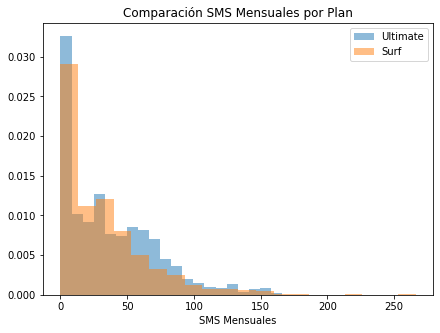

In [ ]:
# Además imprimiremos la proporción en lugar de los conteos
# Comparamos el número de sms que los usuarios de cada plan requieren cada mes por medio de un histograma.
plt.figure(figsize=(7, 5))
plt.hist(megaline_ultimate['sms_per_month'], bins=20, alpha=0.5, label='Ultimate', density=True)
plt.hist(megaline_surf['sms_per_month'], bins=20, alpha=0.5, label='Surf', density=True)

plt.xlabel('SMS Mensuales')
plt.title('Comparación SMS Mensuales por Plan')
plt.legend()

plt.show()

Ahora calcularemos la media y la varianza de la cantidad de SMS por plan, para concluir si los usuarios de diferentes planes muestran comportamientos distintos para los SMS.

In [ ]:
# Calculamos la media y la varianza de la cantidad de SMS mensuales del plan 'Ultimate'

print(f"La media de sms enviados al mes es: {megaline_ultimate['sms_per_month'].mean()}")
print(f"La varianza sms enviados al mes es: {np.var(megaline_ultimate['sms_per_month'])}")

La media de sms enviados al mes es: 37.55138888888889
La varianza sms enviados al mes es: 1207.0779147376543


In [ ]:
# Calculamos la media y la varianza de la cantidad de SMS mensuales del plan 'Surf'

print(f"La media de sms enviados al mes es: {megaline_surf['sms_per_month'].mean()}")
print(f"La varianza sms enviados al mes es: {np.var(megaline_surf['sms_per_month'])}")

La media de sms enviados al mes es: 31.15956770502225
La varianza sms enviados al mes es: 1126.008231726662


 - Para ambos planes, la media de SMS enviados al mes del plan **'Ultimate'** es ligeramente más alta (37) que la del plan **'Surf'** (31).
 - Respecto a la varianza, para el plan **'Ultimate'** es 1207 y para el plan **Surf** es 1126, lo que indica que en ambos casos los valores de **'sms_per_month'** son bastante dispersos respecto a la media.

Para continuar trazaremos un diagrama de caja para visualizar la distribución de la cantidad mensual de sms en ambos planes.

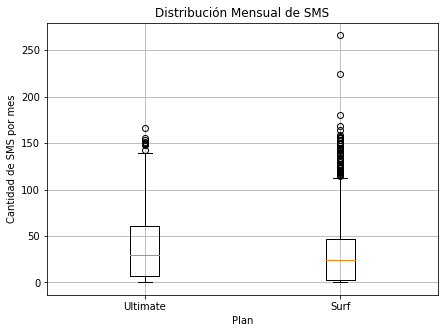

In [ ]:
data_ultimate = megaline_ultimate['sms_per_month']
data_surf = megaline_surf['sms_per_month']
data = [data_ultimate, data_surf]

plt.figure(figsize=(7, 5))
plt.boxplot(data, labels=['Ultimate', 'Surf'])
plt.xlabel('Plan')
plt.ylabel('Cantidad de SMS por mes')
plt.title('Distribución Mensual de SMS')
plt.grid(True)
plt.show()

In [ ]:
# Asismismo revisamos la distribución de SMS mensuales en ambos planes de forma más exacta
# Distribución sms por mes del plan ultimate
megaline_ultimate['sms_per_month'].describe()

count    720.000000
mean      37.551389
std       34.767179
min        0.000000
25%        7.000000
50%       30.000000
75%       61.000000
max      166.000000
Name: sms_per_month, dtype: float64

In [ ]:
# Distribución sms por mes del plan surf
megaline_surf['sms_per_month'].describe()

count    1573.000000
mean       31.159568
std        33.566717
min         0.000000
25%         3.000000
50%        24.000000
75%        47.000000
max       266.000000
Name: sms_per_month, dtype: float64

Como conclusión, analizar el parámetro **'sms_per_month'** pudimos ver que:
 - El promedio de mensajes enviados por mes va aumentando de forma más o menos pareja desde enero a diciembre. Sin embargo, se puede notar que los promedios del plan 'ultimte' son más altos.


 - Al ver el histograma ambos planes los datos están sesgados hacia la derecha. También pudimos observar que la frecuencia del plan surf es bastante superior debido a su cantidad de usuarios. Además pudimos notar que en el plan surf se envían más SMS por usuario que en el plan ultimate (266 versus 166), aunque los usuarios que envían esta cantidad de mensajes son escasos. Por otra parte, el comportamiento representado en los histogramas es bastante similar: ambos tienen un pick que desciende abruptamente, luego tienen otro pick menor y comienzan a descender nuevamente.


 - Para ambos planes, la media de SMS enviados al mes del plan **'Ultimate'** es ligeramente más alta (37) que la del plan **'Surf'** (31).


 - Respecto a la varianza, para el plan **'Ultimate'** es 1207 y para el plan **Surf** es 1126, lo que indica que en ambos casos los valores de **'sms_per_month'** son bastante dispersos respecto a la media.


 - Al observar el histograma pudimos ver que las medianas en ambos planes difieren ligeramente. Pudimos ver valores atípicos en la parte superior fuera de los bigotes. Y también que la concentración de los valores es ligeramente diferente.

### Internet

Ahora estudiaremos el parámetro **'gb_usage'**, que contiene la cantidad GB utilizados por mes por cada usuario. Comenzaremos comparando el número GB usados por mes por los usuarios de ambos planes.

Primero compararemos el promedio de mensajes que tienden a enviar cada mes los usuarios de cada plan. Esto lo haremos por medio de gráficos de barra.

In [ ]:
# Guardamos los promedios de GB enviados por mes y por plan
gb_mean_ultimate = megaline_ultimate.pivot_table(index='date', values='gb_usage')
gb_mean_surf = megaline_surf.pivot_table(index='date', values='gb_usage')

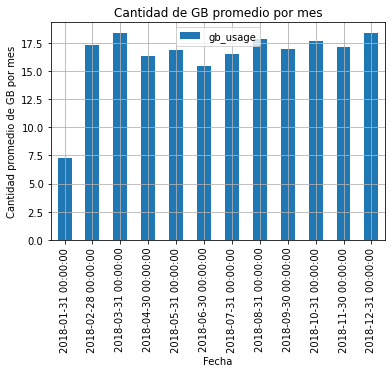

In [ ]:
# Graficamos la cantidad promedio GB usados por mes del plan ultimate
gb_mean_ultimate.plot(kind='bar')

plt.xlabel('Fecha')
plt.ylabel('Cantidad promedio de GB por mes')
plt.title('Cantidad de GB promedio por mes')

plt.grid(True)
plt.show()

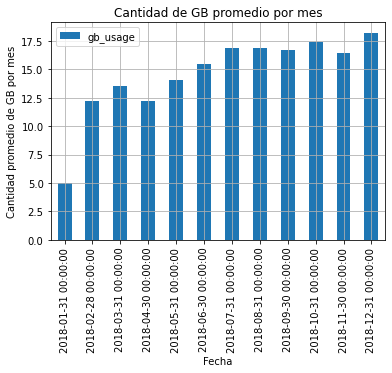

In [ ]:
# Graficamos la cantidad promedio GB usados por mes del plan surf ########
gb_mean_surf.plot(kind='bar')

plt.xlabel('Fecha')
plt.ylabel('Cantidad promedio de GB por mes')
plt.title('Cantidad de GB promedio por mes')

plt.grid(True)
plt.show()

Al observar los gráficos, lo primero que podemos ver es que en ambos planes el promedio de GB utilizados en enero es más bajo que en los otros meses. En el caso de **'Ultimate'** este sube bastante después de enero y más o menos se mantiene así hasta diciembre. En el caso de **'Surf'** podemos ver que desde febrero comienza a ascender de forma sútil hasta diciemre. Al ver el gráfico podemos ver que durante todo el año, los usuarios con el plan **'Ultimate'** utilizan más GB durante los meses.

A continuación compararemos la cantidad de GB que los usuarios de cada plan requieren cada mes, por medio de un histograma.

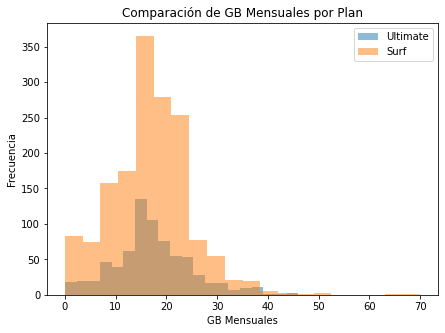

In [ ]:
# Comparamos la cantidad de GB que los usuarios de cada plan requieren cada mes por medio de un histograma.
plt.figure(figsize=(7, 5))
plt.hist(megaline_ultimate['gb_usage'], bins=20, alpha=0.5, label='Ultimate')
plt.hist(megaline_surf['gb_usage'], bins=20, alpha=0.5, label='Surf')

plt.xlabel('GB Mensuales')
plt.ylabel('Frecuencia')
plt.title('Comparación de GB Mensuales por Plan')
plt.legend()

plt.show()

Aquí también podemos ver que el comportamiento de los clientes em ambos planes es bastante parecido. En ambos casos se ve que las cantidades más usadas están entre los 13gb y 25gb. Y muy porcas personas utilizan cantidades después de los 38gb.

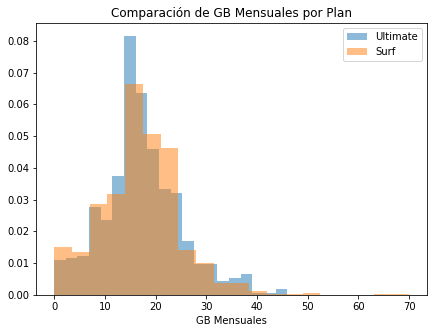

In [ ]:
# Además imprimiremos la proporción en lugar de los conteos
# Comparamos la cantidad de GB que los usuarios de cada plan requieren cada mes por medio de un histograma.
plt.figure(figsize=(7, 5))
plt.hist(megaline_ultimate['gb_usage'], bins=20, alpha=0.5, label='Ultimate', density=True)
plt.hist(megaline_surf['gb_usage'], bins=20, alpha=0.5, label='Surf', density=True)

plt.xlabel('GB Mensuales')
plt.title('Comparación de GB Mensuales por Plan')
plt.legend()

plt.show()

Ahora calcularemos la media y la varianza de la cantidad de GB por plan, para concluir si los usuarios de diferentes planes muestran comportamientos distintos.

In [ ]:
# Calculamos la media y la varianza de la cantidad de GB mensuales del plan 'Ultimate'

print(f"La media de GB enviados al mes es: {megaline_ultimate['gb_usage'].mean()}")
print(f"La varianza GB enviados al mes es: {np.var(megaline_ultimate['gb_usage'])}")

La media de GB enviados al mes es: 17.306944444444444
La varianza GB enviados al mes es: 58.748840663580246


In [ ]:
# Calculamos la media y la varianza de la cantidad de GB mensuales del plan 'Surf'

print(f"La media de GB enviados al mes es: {megaline_surf['gb_usage'].mean()}")
print(f"La varianza GB enviados al mes es: {np.var(megaline_surf['gb_usage'])}")

La media de GB enviados al mes es: 16.670692943420217
La varianza GB enviados al mes es: 61.54444942447023


Cómo podemos ver en los cálculos, la media de ambos planes es casi idéntica. En cuanto a la varianza, para **'ultimate'** es 58 y para **'surf'** es 61, lo que nos indica una dispersión moderada de los datos en ambos casos.

Para continuar trazaremos un diagrama de caja para visualizar la distribución de la cantidad mensual de GB en ambos planes.

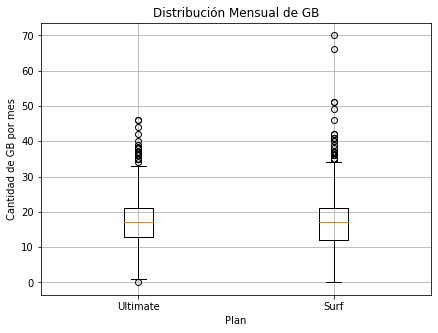

In [ ]:
data_ultimate = megaline_ultimate['gb_usage']
data_surf = megaline_surf['gb_usage']
data = [data_ultimate, data_surf]

plt.figure(figsize=(7, 5))
plt.boxplot(data, labels=['Ultimate', 'Surf'])
plt.xlabel('Plan')
plt.ylabel('Cantidad de GB por mes')
plt.title('Distribución Mensual de GB')
plt.grid(True)
plt.show()

In [ ]:
# Distribución de la cantidad de GB mensual del plan Ultimate
megaline_ultimate['gb_usage'].describe()

count    720.000000
mean      17.306944
std        7.670108
min        0.000000
25%       13.000000
50%       17.000000
75%       21.000000
max       46.000000
Name: gb_usage, dtype: float64

In [ ]:
# Distribución de la cantidad de GB mensual del plan Ultimate
megaline_surf['gb_usage'].describe()

count    1573.000000
mean       16.670693
std         7.847522
min         0.000000
25%        12.000000
50%        17.000000
75%        21.000000
max        70.000000
Name: gb_usage, dtype: float64

Al observar la distribución en el diagrama de bigotes y en las tablas, se ve que es casi identica para ambos casos. La mediana es la misma. Los cuartiles son casi idénticos. Los límites de los vigotes son bastante parecidos. Por otra parte, el plan **'Surf'** posee valores atípicos mucho mayores, pero en general el comportamiento de los usuarios respecto al uso de GB es bastante similar.

Para concluir, pudimos observar que:

 - En ambos casos, la varianza, media, mediana, cuartiles son muy similares; es decir, el comportamiento del uso de GB en ambos planes es muy similar. Por otro lado, al calcular la media de GB utilizados por mes, pudimos ver que en el plan **'Ultimate'** se utilizan más GB en todos los meses.

## Ingreso

Ahora estudiaremos el parámetro **'user_monthly_income'**, que representa el ingreso mensual por usuario en USD. Comenzaremos comparando el promedio de ingresos mensuales de cada plan. Esto lo haremos por medio de gráficos de barra.

In [ ]:
# Guardamos los promedios de los ingresos por mes y por plan
income_mean_ultimate = megaline_ultimate.pivot_table(index='date', values='user_monthly_income')
income_mean_surf = megaline_surf.pivot_table(index='date', values='user_monthly_income')

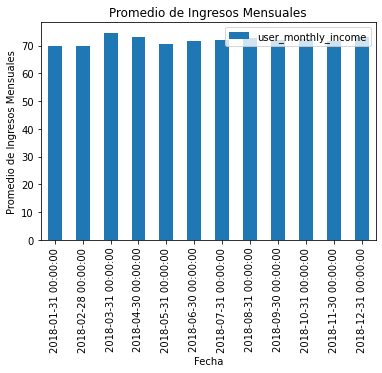

In [ ]:
# Graficamos los promedios de ingresos mensuales del plan Ultimate
income_mean_ultimate.plot(kind='bar')

plt.xlabel('Fecha')
plt.ylabel('Promedio de Ingresos Mensuales')
plt.title('Promedio de Ingresos Mensuales')

plt.show()

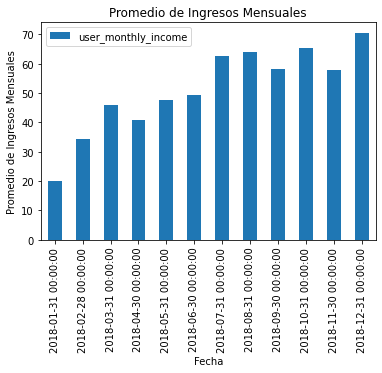

In [ ]:
# Graficamos los promedios de ingresos mensuales del plan Surf
income_mean_surf.plot(kind='bar')

plt.xlabel('Fecha')
plt.ylabel('Promedio de Ingresos Mensuales')
plt.title('Promedio de Ingresos Mensuales')

plt.show()

En el gráfico de los ingresos del plan **'Ultimate'** el promedio mensual se mantiene bastante parejo, rondando los 70 usd en todos los meses. En cambio en el plan **'Surf'**, el promedio del mes de enero es de al rededor de 20USD y comienza a subir progresivamente hasta llegar a un promedio de 70USD en diciembre.

A continuación compararemos los ingresos mensuales generados por los usuarios de cada plan, por medio de un histograma.

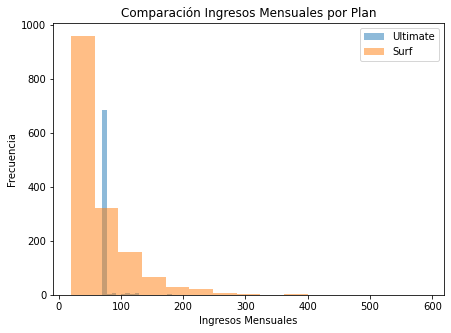

In [ ]:
# Comparamos la cantidad de GB que los usuarios de cada plan requieren cada mes por medio de un histograma.
plt.figure(figsize=(7, 5))
plt.hist(megaline_ultimate['user_monthly_income'], bins=15, alpha=0.5, label='Ultimate')
plt.hist(megaline_surf['user_monthly_income'], bins=15, alpha=0.5, label='Surf')

plt.xlabel('Ingresos Mensuales')
plt.ylabel('Frecuencia')
plt.title('Comparación Ingresos Mensuales por Plan')
plt.legend()

plt.show()

Como nos muestra el histograma, en el caso de **'Ultimate'** la mayoría de usuarios generan ingresos entre 70 y 80USD, mientras que en el plan **Surf** los ingresos por usuarios son bastante más diversos, además se puede ver que los valores más frecuentes en este plan son menores que los del plan **'Ultimate'**.

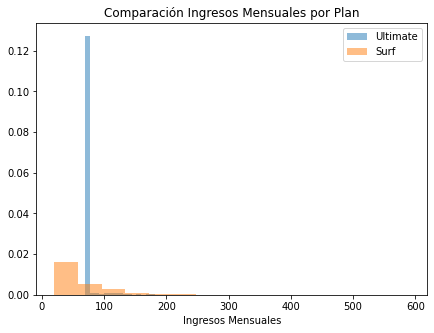

In [ ]:
# Además imprimiremos la proporción en lugar de los conteos
# Comparamos la cantidad de GB que los usuarios de cada plan requieren cada mes por medio de un histograma.
plt.figure(figsize=(7, 5))
plt.hist(megaline_ultimate['user_monthly_income'], bins=15, alpha=0.5, label='Ultimate', density=True)
plt.hist(megaline_surf['user_monthly_income'], bins=15, alpha=0.5, label='Surf', density=True)

plt.xlabel('Ingresos Mensuales')
plt.title('Comparación Ingresos Mensuales por Plan')
plt.legend()

plt.show()

Ahora calcularemos la media y la varianza de los ingresos mensuales por plan, para concluir si los usuarios de diferentes planes muestran comportamientos distintos.

In [ ]:
# Calculamos la media y la varianza de los ingresos mensuales del plan 'Ultimate'

print(f"La media de ingresos mensuales es: {megaline_ultimate['user_monthly_income'].mean()}")
print(f"La varianza de ingresos mensuales es: {np.var(megaline_ultimate['user_monthly_income'])}")

La media de ingresos mensuales es: 72.31388888888888
La varianza de ingresos mensuales es: 129.66814043209877


In [ ]:
# Calculamos la media y la varianza de los ingresos mensuales del plan 'Surf'

print(f"La media de ingresos mensuales es: {megaline_surf['user_monthly_income'].mean()}")
print(f"La varianza de ingresos mensuales es: {np.var(megaline_surf['user_monthly_income'])}")

La media de ingresos mensuales es: 60.69807374443739
La varianza de ingresos mensuales es: 3065.4499409176387


De acuerdo a los cálculos, la media del plan **'Ultimate'** es mayor a la de **'Surf'**. Por otro lado, la varianza del plan **'Ultimate'** nos indica que existe una dispersión moderada de los valores en relación con la media.Y la varianza del plan **'Surf'** nos indica una dispersión amplia de los datos en relación con la media.

Para continuar trazaremos un diagrama de caja para visualizar la distribución de los ingresos mensuales en ambos planes.

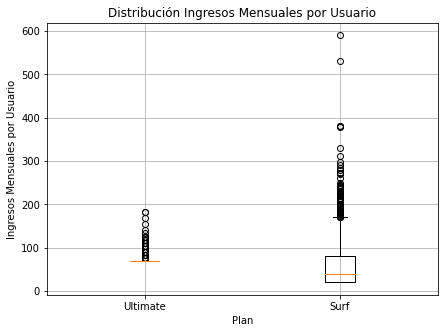

In [ ]:
data_ultimate = megaline_ultimate['user_monthly_income']
data_surf = megaline_surf['user_monthly_income']
data = [data_ultimate, data_surf]

plt.figure(figsize=(7, 5))
plt.boxplot(data, labels=['Ultimate', 'Surf'])
plt.xlabel('Plan')
plt.ylabel('Ingresos Mensuales por Usuario')
plt.title('Distribución Ingresos Mensuales por Usuario')
plt.grid(True)
plt.show()

Al observar el diagrama de caja vemos que para el plan **Ultimate** la mayoría de los valores se concentran más o menos en los 70 USD. Mientras que en el plan **'Surf'** los valores están más dispersos y su mediana es mas baja (40).

In [ ]:
# Distribución de ingresos mensuales por usuario del plan Ultimate
megaline_ultimate['user_monthly_income'].describe()

count    720.000000
mean      72.313889
std       11.395108
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      182.000000
Name: user_monthly_income, dtype: float64

In [ ]:
# Distribución de ingresos mensuales por usuario del plan Surf
megaline_surf['user_monthly_income'].describe()

count    1573.000000
mean       60.698074
std        55.384113
min        20.000000
25%        20.000000
50%        40.360000
75%        80.360000
max       590.250000
Name: user_monthly_income, dtype: float64

Al analizar el parámetro e ingresos mensuales por usuario podemos concluir que:
 - En el gráfico de los ingresos del plan 'Ultimate' el promedio mensual se mantiene bastante parejo, rondando los 70 usd en todos los meses. En cambio en el plan 'Surf', el promedio del mes de enero es de al rededor de 20USD y comienza a subir progresivamente hasta llegar a un promedio de 70USD en diciembre.


- Como nos muestró el histograma, en el caso de **'Ultimate'** la mayoría de usuarios generan ingresos entre 70 y 80USD, mientras que en el plan **Surf** los ingresos por usuarios son bastante más diversos, además vimos que los valores más frecuentes en este plan son menores que los del plan **'Ultimate'**.


 - De acuerdo a los cálculos, la media del plan **'Ultimate'** es mayor a la de **'Surf'**. Por otro lado, la varianza del plan **'Ultimate'** nos indica que existe una dispersión moderada de los valores en relación con la media.Y la varianza del plan **'Surf'** nos indica una dispersión amplia de los datos en relación con la media.


 - Al observar el diagrama de caja vimos que para el plan **Ultimate** la mayoría de los valores se concentran más o menos en los 70 USD. Mientras que en el plan **'Surf'** los valores están más dispersos y su mediana es mas baja (40).


## Probar las hipótesis estadísticas.


### Prueba 1

En la última parte de nuestro estudio, probaremos la siguiente hipotesis : "El ingreso promedio de los usuarios de los planes de llamada **Ultimate** y **Surf** es diferente". Para esto utilizaremos una prueba de hipótesis de dos poblaciones y de dos colas; estableciendo la hipotesis nula y alternativa como:

 - H0: El ingreso promedio de los usuarios de los planes de llamada **Ultimate** y **Surf** es el mismo.
 - H1: El ingreso promedio de los usuarios de los planes de llamada **Ultimate** y **Surf** es diferente.

In [ ]:
# Probamos las hipótesis

# Varianzas de ingresos mensuales de Ultimate es 129.6
# Varianza de ingresos mensuales de Surf es 3065.4
# Dejamos el parámetro 'equal_var' en 'False' debido a la variabilidad de las varianzas
results = ttest_ind(
    megaline_surf['user_monthly_income'],
    megaline_ultimate['user_monthly_income'],
    equal_var = False
)
# Establecemos el valor alfa
alpha = 0.05

print('p-value:', results.pvalue)

if results.pvalue < alpha:
     print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")


p-value: 3.0199000830260373e-15
Rechazamos la hipótesis nula


De acuerdo a lo que nos indica el P-value, tenemos suficiente evidencia para rechazar la hipotesis nula.
En este caso nuestro valor P es minúsculo () y mucho menor que el valo alfa, esto significa que la probabilidad de que no haya diferencia entre los ingresos promedio de los usuarios de los planes **Surf** y **Ultimate** es extremadamente baja.

### Prueba 2

Ahora probaremos la siguiente hipotesis : "El ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones". Para esto también utilizaremos una prueba de hipótesis de dos poblaciones y de dos colas; estableciendo la hipotesis nula y alternativa como:

 - H0: El ingreso promedio de los usuarios del área NY-NJ es el **mismo** al de los usuarios de otras regiones.
 - H1: El ingreso promedio de los usuarios del área NY-NJ es **diferente** al de los usuarios de otras regiones.

Para esto primero crearemos tablas filtradas con los datos necesarios para llevar a cabo el test.

In [ ]:
# Filtramos la tabla 'megalinev3' solo con usuarios del área de NY_NJ
megaline_ny_nj = megalinev3[megalinev3['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA']

# Filtramos la tabla 'megalinev3' con los usuarios de las otras regiones
megaline_other_regions = megalinev3[megalinev3['city']!='New York-Newark-Jersey City, NY-NJ-PA MSA']

In [ ]:
# Revisamos las varianzas de ambas tablas
print(f"La varianza de 'megaline_ny_nj' es: {np.var(megaline_ny_nj['user_monthly_income'])}")
print(f"La varianza de 'megaline_other_regions' es: {np.var(megaline_other_regions['user_monthly_income'])}")

La varianza de 'megaline_ny_nj' es: 1890.3503082256261
La varianza de 'megaline_other_regions' es: 2223.608473677547


In [ ]:
# Probamos las hipótesis

# Dejamos el parámetro 'equal_var' en 'False' debido a la variabilidad de las varianzas
results_1 = ttest_ind(
    megaline_ny_nj['user_monthly_income'],
    megaline_other_regions['user_monthly_income'],
    equal_var = False
)
# Establecemos el valor alfa
alpha = 0.05

print('p-value:', results_1.pvalue)

if results_1.pvalue < alpha:
     print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

p-value: 0.033440767667409964
Rechazamos la hipótesis nula


En este caso, dado que el P-value es menor que el valor alfa, tenemos evidencia, nuevamente, para rechazar la hipotesis nula. De este modo, se puede decir que hay indicios que nos indican que el ingreso promedio de los usuarios del área de 'NY-NJ' es diferente al de los usuarios de otras regiones.

## Conclusión general

Como conclusión, para responder a la pregunta: "cuál de los planes genera más ingresos para ajustar el presupuesto de publicidad", realizamos dos pruebas:

 - Para la hipotesis "El ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones", establecimos las siguintes hipotesis nulas:
  - H0: El ingreso promedio de los usuarios de los planes de llamada **Ultimate** y **Surf** es el mismo.
  - H1: El ingreso promedio de los usuarios de los planes de llamada **Ultimate** y **Surf** es diferente.

Donde en este caso el P-value fue extremadamente menor al alpha, lo que nos dio evidencia para rechazar la hipótesis nula. En otras palabras, concluimos, de acuerdo a la evidencia, **los ingresos de los usuarios son diferentes en ambos planes**.

- Por otra parte estudiamos la hipotesis "El ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones", donde se establecieron las hipotesis:
 - H0: El ingreso promedio de los usuarios de los planes de llamada **Ultimate** y **Surf** es el mismo.
 - H1: El ingreso promedio de los usuarios de los planes de llamada **Ultimate** y **Surf** es diferente.

Donde, nuevamente el valor alfa fue mayor que el P-value, lo que nos dio evidencia para rechazar esta hipótesis nula. Es decir, de acuerdo a la evidencia, concluimos que **los ingresos de los usuarios de 'NY-NJ' son distintos a los de usuarios de otras regiones**.

Asimismo, al calcular la media del plan **Ultimate** (72,31) y la del plan **Surf** (60.69), podemos concluir que los usuarios del plan **Ultimate** generan más ingresos, con una diferencia aproximada de 12USD.



 - Este análisis se llevó a cabo por medio de las tablas 'calls', 'internet', 'messages', que nos entregaron información sobre el uso de los planes por cada uno de los 500 usuarios. Es decir, duración de llamadas, sms enviados y mb utilizados.
 - Estudiamos las tres tablas y corregimos sus datos. Para esto revisamos duplicados, formatos de las columnas y de sus nombres, valores ausentes y en algunos casos enriquecimos los datos.
 - Para la columna 'duration' de la tabla 'calls' redondeamos los segundos a minutos, y para la tabla 'internet', con la columna columna 'mb_used' creamos otra columna con gigabytes redondeados.
 -Por medio de estas tablas calculamos el uso de gigabytes, duración de llamadas, número de sms y el número de llamadas por mes por usuario.
 - Además se nos entregaron otras tablas llamadas 'plans' y 'users', que unimos con nuestras tablas anteriores, generando una sola tabala llamada 'megalinev3'. En esta tabla calculados los ingresos mensuales por usuario, sumando el costo por plan y los excedentes de uso de SMS, GB y minutos de llamadas.
 - Luego estudiamos el comportamiento por usuario en ambos planes, en los parámetros 'llamadas', 'mensajes', 'sms', 'internet' e 'ingresos'. Aquí el comportamiento de los usuarios en ambos planes para 'llamadas' y 'mensajes' era bastante similar. En cambio en el parámetros 'internet' se pudo observar un comportamiento distinto para los usuarios de ambos planes.
 - Al analizar los ingresos, también se observaron diferencias entre planes, donde, a grandes rasgos, en el plan **ultimate** se observó un ingreso promedio más alto desde el comienzo del año 2018.
 - Finalmente probamos las siguiente hipotesis:
  - "El ingreso promedio de los usuarios de los planes de llamada Ultimate y Surf es diferente."
  - "El ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones."

En ambos casos la hipótesis nula fue rechazada. De este modo pudimos concluir que los ingresos en ambos planes son distintos y que por medio del plan **Ultimate** se generan más ingresos.

 <div class="alert alert-block alert-success">
<b>Comentario del evaluador</b> <a class="tocSkip"></a>

¡Hola!
    
Te quiero felicitar por tu trabajo, está bastante completo y muy bien realizado. El código es correcto y se nota que te desenvuelves con facilidad en python. Un consejo en general sería que definas más funciones para reducir líneas de código en procesos que repites, esto te resultará muy útil.
    
Realicé algunos comentarios en bloques de color amarillo, pero en general me parece bueno tu proyecto por lo que puedo aprobarlo.
    
Saludos y éxito,

</div>